# MLFlow 2 

In [1]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# un nouvel import utile pour la 3D:
from matplotlib import cm
import seaborn as sns
sns.set_style("whitegrid")

# Les instructions suivantes sont TRES utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# Pour mesurer le temps
import time
import random
import graphviz as gv


# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Import MLFlow
import mlflow
mlflow.end_run()
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import cross_val_score

In [3]:
mlflow.set_tracking_uri("http://127.0.0.1:8080")

apple_experiment = mlflow.set_experiment("perceptron")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "perceptron"

# Define an artifact path that the model will be saved to.
artifact_path = "perceptron"

# Démarrer un nouvel experiment
mlflow.start_run()

KeyboardInterrupt: 

In [ ]:
# Prepare data
# Charger les données
file_path = "../../data/Loan_Data_Preprocessed.csv"
df = pd.read_csv(file_path)

#  Séparer les features et la cible
X = df.drop(columns=['customer_id', 'default'])  # Exclure l'ID client et la cible
y = df['default']

# Définition de variables
X_noms = X.columns

# Conversion en np.ndarray
X = np.array(X)
y = np.array(y)

# Définition de variables
dim = len(X[0])
nb_labels = len(np.unique(y))

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
np.random.seed(42)
(train_desc, train_label), (test_desc, test_label) = ut.genere_train_test(X, y,100)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label


index = random.sample(range(len(X)),7000)
data_cv, label_cv = X[index], y[index]

## Perceptron

In [ ]:
# Configure param grid
param_grid = {
    'learning_rate': [0.01, 0.001, 0.005],
    'init': [True, False],
}

# Initialisation du modèle Perceptron
perceptron = classif.ClassifierPerceptron(dim)
# GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(estimator=perceptron, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(data_train, label_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Utiliser le meilleur modèle pour prédire
best_rf = grid_search.best_estimator_
y_pred = np.array(
    [best_rf.predict(data_test[i]) for i in range(len(data_test))]
)

# Calcul des métriques avec le meilleur modèle
accuracy = accuracy_score(test_label, y_pred)
report = classification_report(test_label, y_pred)

# Log des résultats
mlflow.log_param("best_params", grid_search.best_params_)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_text(report, "classification_report_optimized.txt")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ......................init=True, learning_rate=0.01; total time=   0.0s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.0s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.1s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END ......................init=True, learning_rate=0.01; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.0s
[CV] END .....................init=True, learning_rate=0.005; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning_rate=0.001; total time=   0.1s
[CV] END .....................init=True, learning

/Users/hoangthuyduongvu/miniconda3/envs/banking-mlops/lib/python3.13/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


In [ ]:
# Creat perceptron on best params
best_rf = classif.ClassifierPerceptron(dim, learning_rate=0.01, init=True)

In [ ]:
# -----
# Apprentissage pas à pas du perceptron et mémorisation de l'accuracy à chaque étape:
# Listes qui vont servir à mémoriser les accuracy du perceptron à chaque étape:
train_acc = []
test_acc = []

# Réalisation de N itérations
N = 15
for i in range(N) : 
    L_train = best_rf.train(data_train, label_train)
    train_acc.append(best_rf.accuracy(data_train, label_train))
    
    L_test = best_rf.train(data_test, label_test)
    test_acc.append(best_rf.accuracy(data_test, label_test))

# -----
# Traçage de la courbe des variations d'accuracy
plt.figure(figsize=(10,2))
plt.plot(range(1,N+1),train_acc, c='r', label='Train') 
plt.plot(range(1,N+1),test_acc, c='b', label='Test')
plt.legend()
plt.title('Accuracy du perceptron en fonction des itérations') 
plt.ylabel('Accuracy')
plt.xlabel("Etape")


print("Accuracy finale (train): ", train_acc[len(train_acc)-1])
print("Accuracy finale (test) : ", test_acc[len(test_acc)-1])

# plt.savefig("acc_perceptron.png")
mlflow.log_artifact("acc_perceptron.png")

: 

In [ ]:
print("------ affichage validation croisée")

#################################

# ce qui se passe:
tic= time.time()
(res_all, res_moy, res_sd) = ev.validation_croisee(best_rf, (data_cv, label_cv), 10)
toc= time.time()

print("------ fin affichage validation croisée")

print("Validation croisée sur pen_dataset :")
print("Perf obtenues : ",res_all)
print(f'Accuracy moyenne: {res_moy:0.3f}\técart type: {res_sd:0.4f}')
print(f'Résultat en {(toc-tic):0.4f} secondes.')

------ affichage validation croisée
Itération 0  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9814285714285714
Itération 1  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9814285714285714
Itération 2  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9814285714285714
Itération 3  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9871428571428571
Itération 4  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9828571428571429
Itération 5  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9771428571428571
Itération 6  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9642857142857143
Itération 7  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9871428571428571
Itération 8  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9842857142857143
Itération 9  : taille base a

Text(0.5, 1.0, 'Validation croisée sur perceptron')

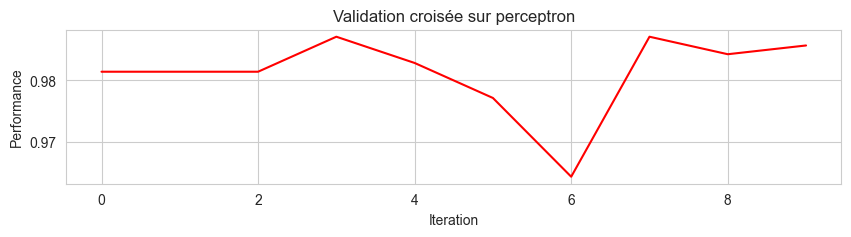

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(res_all, c='r')
plt.ylabel('Performance')
plt.xlabel("Iteration")
plt.title("Validation croisée sur perceptron")
# plt.savefig("cross_val_perceptron.png")
mlflow.log_artifact("cross_val_perceptron.png")

### vis

In [ ]:
y_test_pred = np.array([
    best_rf.predict(data_test[i]) for i in range(len(data_test))
])

In [ ]:
y_test_pred

array([0, 0, 0, ..., 1, 1, 1], shape=(9800,))

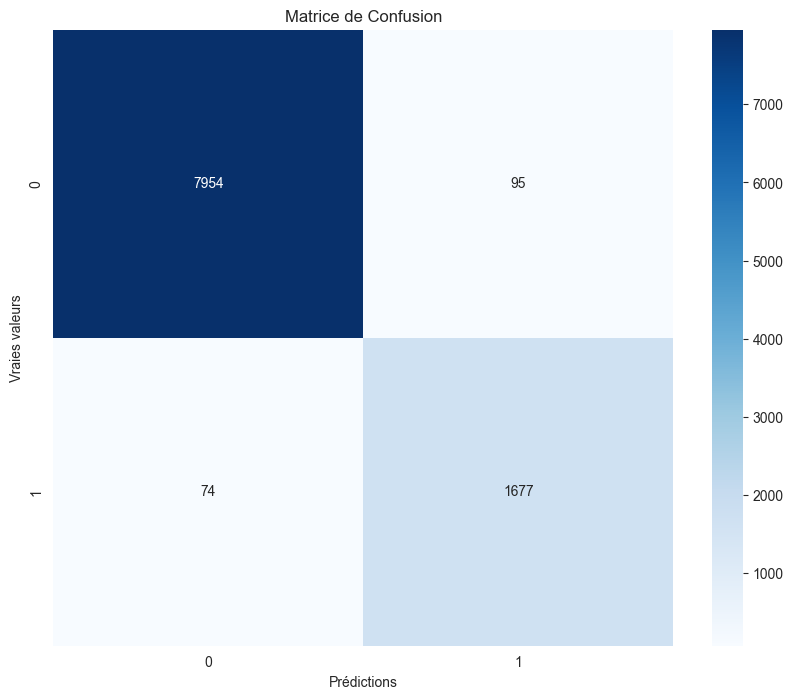

In [ ]:
#  Matrice de confusion
cm = confusion_matrix(label_test, y_test_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")

# Sauvegarde de l'image de la matrice de confusion
plt.savefig("confusion_matrix.png")

# Enregistrement de l'image dans MLflow
mlflow.log_artifact("confusion_matrix.png")

# Affichage de la matrice
plt.show()


In [ ]:
y_proba = best_rf.predict_proba(data_test)

In [ ]:
best_rf.predict_proba(data_test)

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], shape=(9800, 10))

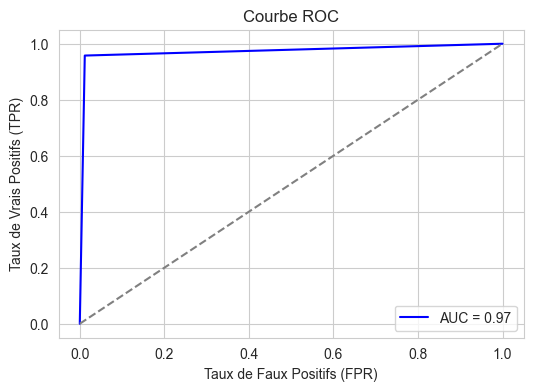

In [ ]:
# Prédictions de probabilité pour la classe positive (1)
y_proba = best_rf.predict_proba(data_test)[:, 1]  # Probabilités pour la classe 1

#  Courbe ROC et AUC
fpr, tpr, _ = roc_curve(label_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")

# Sauvegarde de la courbe ROC
# plt.savefig("roc_curve.png")
# mlflow.log_artifact("roc_curve.png")  # Enregistrement dans MLflow

plt.show()

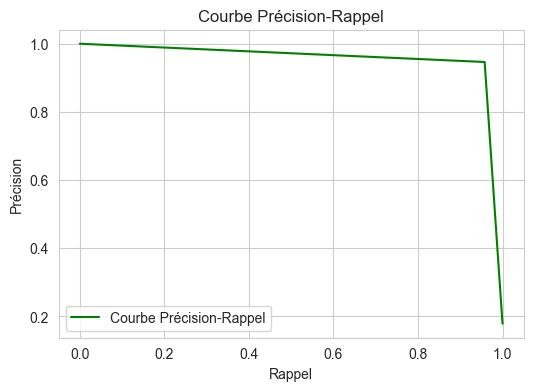

In [ ]:
#  Courbe Précision-Rappel
precision, recall, _ = precision_recall_curve(label_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="green", label="Courbe Précision-Rappel")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="lower left")

# plt.savefig("precision_recall_curve.png")
# mlflow.log_artifact("precision_recall_curve.png")  
# plt.show()